# Replica Prediction and Scheduling

In [61]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from matching.games import HospitalResident
from operator import itemgetter
import yaml
import json
import sys
from io import StringIO
import warnings
warnings.filterwarnings('ignore', "\nPyarrow", DeprecationWarning)

In [62]:
import scipy.stats as ss
import random
random.seed(42)
random_seed = 42

Data

In [63]:
start_time = time.monotonic()

# Load the CSV file into a DataFrame
file = r'dataset-replica-mcr-mt.csv'
df = pd.read_csv(file)

# dataset
dataset = df.values
X = ((dataset[:, 5]) * (dataset[:, 6]/1000)) # mcr*deadline
print(len(X), " ",np.min(X), " ",np.max(X), " ", list(X).index(np.max(X)))
Y = dataset[:, 4] #  column
print(len(Y), " ", np.min(Y)," ", np.max(Y))

44902   1.0001564692511276   23979.15890590625   5548
44902   1   59


Scatter

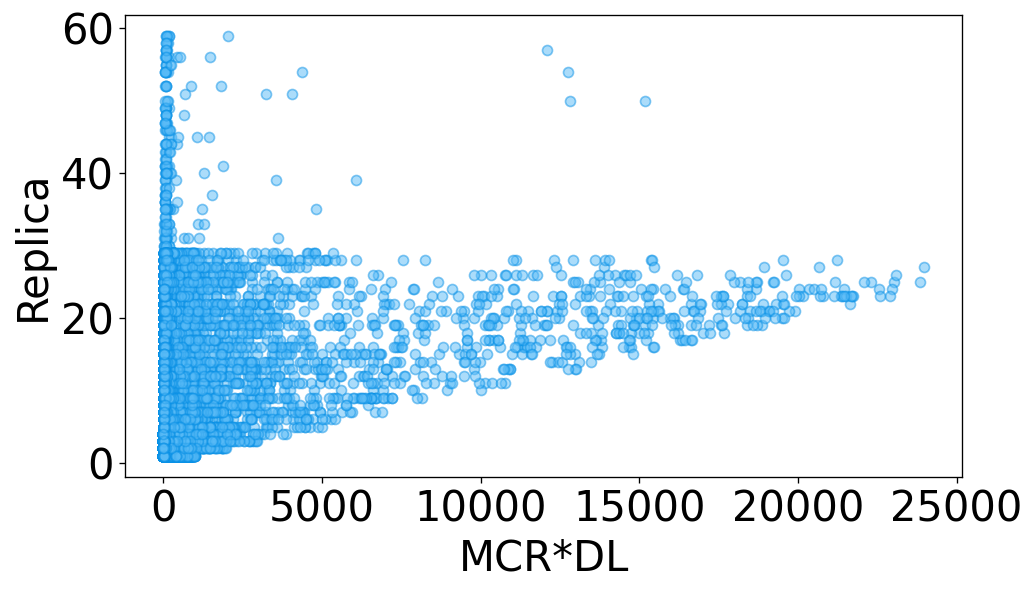

In [64]:
plt.figure(figsize=(9, 5), dpi=120)
plt.scatter(x=X, y=Y, color="#59bbf7", marker="o",alpha=0.5, edgecolors="#0991e6")
plt.subplot().tick_params(labelsize=25)
plt.ylabel('Replica', fontsize=25)
plt.xlabel('MCR*DL', fontsize=25)
plt.show()

Reshape + Split

In [65]:
X = X.reshape(-1, 1)
Y = Y.reshape(-1, 1)

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
#X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)
print("Train: ", X_train.shape)
#print("Val: ", X_val.shape)
print("Test: ", X_test.shape)

Train:  (35921, 1)
Test:  (8981, 1)


## MLP

In [66]:
from sklearn.neural_network import  MLPRegressor
from sklearn.experimental import enable_halving_search_cv
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
'''
model_nn = MLPRegressor(
    solver = 'adam', 
    max_iter = 10000
)

parameters_nn = {
    'hidden_layer_sizes': [
        (40, 20, 10, 5, 2, ),
        (40, 30, 20, 15, 12, 10, 8, 6, 4, 2, ),
        (100, 50, 25, 12, 6, 3, ), 
        (60, 50, 40, 30, 20, 10, ),
        (1000, 100, 10, ),
        (200, 100, 50, 25, 12, 6, 3, 2, ),  
    ],
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'alpha': ss.loguniform(1e-5, 1e-3),
    'beta_1': ss.uniform(0.5, 0.5),
    'beta_2': ss.uniform(0.9, 0.1),
    'epsilon': ss.loguniform(1e-9, 1e-7),
    'learning_rate_init': ss.uniform(0.001, 0.8),
}

def halving_search(model, parameters):
    return model_selection.HalvingRandomSearchCV(
        estimator = model,
        param_distributions = parameters,
        n_candidates = search_n_candidates,
        factor = search_factor,
        aggressive_elimination = search_agg_elimination,
        cv = search_cv,
        scoring = search_scoring, 
        n_jobs = search_n_jobs,
        verbose = search_verbose,
        random_state=random_seed,
    )
# Rescale 
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

# Fit and transform X_train, and fit (but not transform) y_train
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
Y_train_scaled = scaler_Y.fit_transform(Y_train)  # Reshape y if it's 1D

search_nn = halving_search(model_nn, parameters_nn).fit(X_train_scaled, Y_train_scaled)
# fill predictions
Y_predict_mlp_1 = search_nn.best_estimator_.predict(X_test_scaled)
#print(len(Y_predict_mlp_1))
print(search_nn.best_estimator_)'''

# Rescale 
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

# Fit and transform X_train, and fit_transform Y_train
X_train_scaled = scaler_X.fit_transform(X_train)
Y_train_scaled = scaler_Y.fit_transform(Y_train)  

mlp_sk_learn = MLPRegressor(hidden_layer_sizes=(3),solver = 'adam', max_iter = 10000)

# Train a model
mlp_sk_learn.fit(X_train_scaled,Y_train_scaled)

C:\Users\b1108190\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLPRegressor(hidden_layer_sizes=3, max_iter=10000)

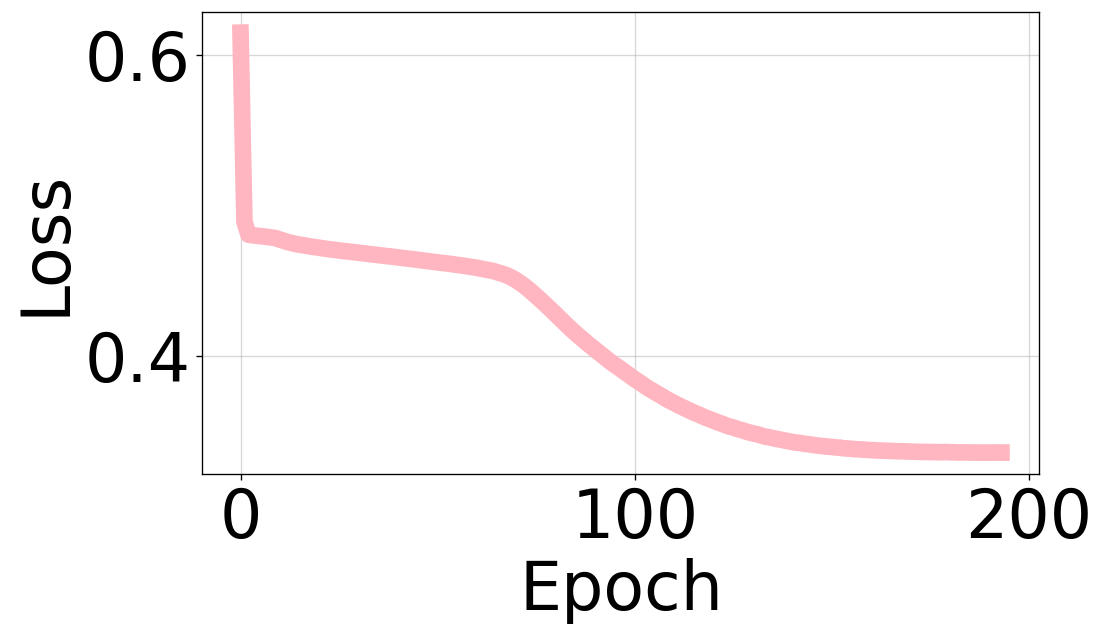

In [67]:
fig, ax = plt.subplots(figsize=(9, 5), dpi=120)
ax.plot(mlp_sk_learn.loss_curve_, color='lightpink', linewidth=10)
plt.subplot().tick_params(labelsize=40)
ax.set_xlabel('Epoch', fontsize=40)
ax.set_ylabel('Loss', fontsize=40)
#plt.yticks(range(8, 22, 2))
ax.grid(True, alpha=0.5)
#plt.show()
plt.savefig("mlp_validation.pdf", format="pdf", bbox_inches="tight")

In [68]:
#print(np.array([[2*10,]]).shape)
print("Test_before: ", X_test.shape)
init_test_len = X_test.shape[0]
X_test.resize((init_test_len+5,1))
Y_test.resize((init_test_len+5,1))

X_test[init_test_len] = 2*2.7
Y_test[init_test_len] = 2

X_test[init_test_len+1] = 2*31
Y_test[init_test_len+1] = 2

X_test[init_test_len+2] = 2*33
Y_test[init_test_len+2] = 2

X_test[init_test_len+3] = 2*17
Y_test[init_test_len+3] = 2

X_test[init_test_len+4] = 2*0.25
Y_test[init_test_len+4] = 2
print("Test_after: ", (X_test).shape)

Test_before:  (8981, 1)
Test_after:  (8986, 1)


In [69]:
replica_actual = []
for i in range(len(X_test)):
    replica_actual.append(np.ceil(Y_test[i]))

# Scale X_test
X_test_scaled = scaler_X.transform(X_test)

# Predict
Y_predict_mlp_scaled = mlp_sk_learn.predict(X_test_scaled)

# Inverse transform X_test
X_test_original = scaler_X.inverse_transform(X_test_scaled)

# Inverse transform the predictions and the actual Y_test to get back to the original scale
Y_predict_mlp = scaler_Y.inverse_transform(Y_predict_mlp_scaled.reshape(-1,1))
Y_predict_mlp = np.reshape(Y_predict_mlp, [Y_test.shape[0], 1])

# Replica estimation
replica_mlp = []
for i in range(len(X_test)):
    replica_mlp.append(np.ceil(Y_predict_mlp[i]))

In [70]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

mae = mean_absolute_error(Y_test, Y_predict_mlp)
mape = mean_absolute_percentage_error(Y_test, Y_predict_mlp)
mse = mean_squared_error(Y_test, Y_predict_mlp)
rmse_test = mse ** 0.5
#mape = mean_absolute_percentage_error(Y_val, Y_predict_mlp)
#mae = mean_absolute_error(Y_val, Y_predict_mlp)
#mse = mean_squared_error(Y_val, Y_predict_mlp)
print(f"MAPE : {mape}")
print(f"MAE : {mae}")
print(f"MSE : {mse}")
print(f"RMSE: {rmse_test}")

MAPE : 1.2571478001661784
MAE : 5.047988821820752
MSE : 46.25623534343604
RMSE: 6.8011936704843245


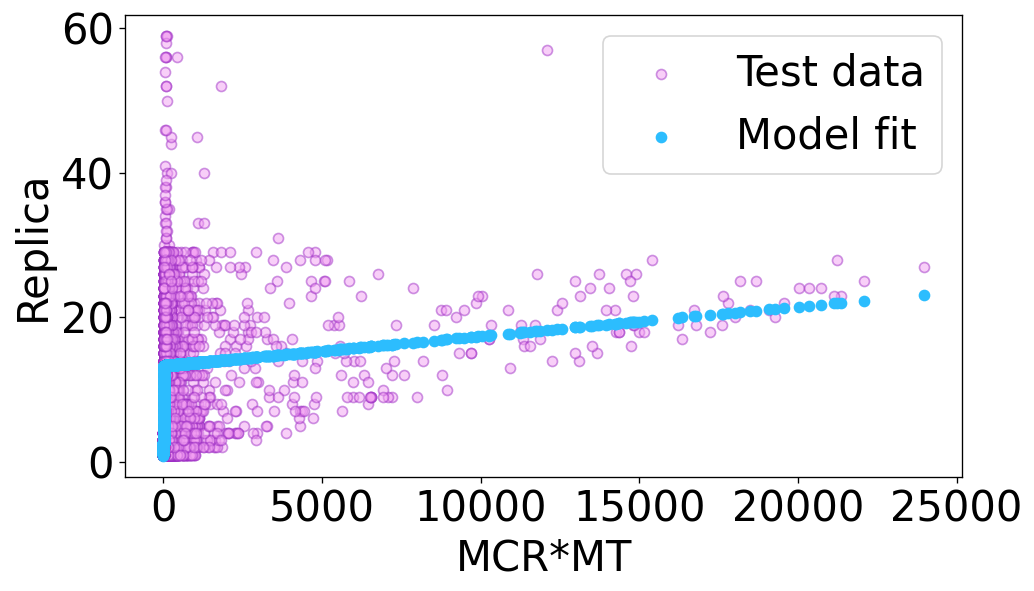

In [71]:
fig, ax = plt.subplots(figsize=(9, 5), dpi=120)
ax.scatter(x=X_test, y=Y_test, color="#F3A0F2", marker="o",alpha=0.5, edgecolors="#9D2EC5", label= 'Test data')
#plt.scatter(x=X_test, y=Y_test, color="#F3A0F2", marker="o",alpha=0.5, edgecolors="#9D2EC5", label= 'Test data')
plt.subplot().tick_params(labelsize=25)
ax.scatter(x=X_test, y=Y_predict_mlp, color="#2CBDFE", linewidth=1, label= 'Model fit')
plt.ylabel('Replica', fontsize=25)
plt.xlabel('MCR*MT', fontsize=25)
plt.legend(loc="best", bbox_to_anchor =(1,1),fontsize=25, ncol=1)
#plt.show()
plt.savefig("mlp_prediction.pdf", format="pdf", bbox_inches="tight")

In [72]:
print()

print("MAPE : ", np.round(mean_absolute_percentage_error(np.array(replica_actual), np.array(replica_mlp)),4))

print("MAE : ", np.round(mean_absolute_error(np.array(replica_actual), np.array(replica_mlp)),4))

print("MSE : ", np.round(mean_squared_error(np.array(replica_actual), np.array(replica_mlp)),4))

print("RMSE : ", np.round(mean_squared_error(np.array(replica_actual), np.array(replica_mlp))**0.5,4))

print("Actual number of replicas (min.): ",np.round(np.min(np.array(replica_actual)),0))
print("Predicted number of replicas (min.): ",np.round(np.min(np.array(replica_mlp)),0))

print("Actual number of replicas (avg.): ",np.round(np.average(np.array(replica_actual)),0))
print("Predicted number of replicas (avg.): ",np.round(np.average(np.array(replica_mlp)),0))

print("Actual number of replicas (max.): ",np.round(np.max(np.array(replica_actual)),0))
print("Predicted number of replicas (max.): ",np.round(np.max(np.array(replica_mlp)),0))


MAPE :  1.3695
MAE :  5.1098
MSE :  46.5398
RMSE :  6.822
Actual number of replicas (min.):  1
Predicted number of replicas (min.):  1.0
Actual number of replicas (avg.):  9.0
Predicted number of replicas (avg.):  10.0
Actual number of replicas (max.):  59
Predicted number of replicas (max.):  24.0


In [73]:
def comp_times(resources,task ,rec, num_of_src):
    #print(num_of_src)

    #             Exo(small) Exo(med) Exo(lg)  EGS  Lenovo  NJN   RPi4   RPi3
    encode_200   = [0.44,   0.4,   0.27,        0.17, 0.33,  1.9,  2.16,   2.5] #seconds
    encode_1500  = [0.65,   0.62,   0.5,        0.36, 0.42, 2.63,  3.19,  7.35] #seconds
    encode_3000  = [0.9,   0.89,   0.65,        0.47, 0.59, 3.48,   4.4,  8.44] #seconds
    encode_6500  = [2.7,   2.58,   1.43,         1.22, 1.59, 9.68,  11.8,  22.7] #seconds
    encode_20000 = [6.2,    6.1,    3.1,         2.7, 3.16, 20.64,   28,    60] #seconds

    #             Exo(small) Exo(med) Exo(lg) EGS  Lenovo  NJN   RPi4   RPi3
    frame_200   = [0.84,     0.8,  0.5,  0.5,  0.6,    2,    4, 11]
    frame_1500  = [2.2,       1.8,   2,  2.5,    2,  9.4,   11, 20]
    frame_3000  = [2.9,       2.5,   3,  3.7,  3.1,   14,   14, 26]
    frame_6500  = [9,       8.7,     9,   14, 13.5,   55,   49, 88]
    frame_20000 = [21,      18.5,   18,   31,   31,  117,  112, 204]

    # 		      Exo(small) Exo(med) Exo(lg)     EGS  Lenovo  NJN   RPi4   RPi3
    inference = [     0.29,    0.26,   0.25,    0.23,  0.28,  1.94,  1.1, 1.5]
    lowtrain =   [    32,    26.5,     25.76,      17,    18,   152,  102, 1000] #seconds
    hightrain =  [     190,     103,    70.6,      33,    57,   232,  467, 1000] #seconds

    #    			  BG, FRA VIE Gateway Lenovo NANO  RPI4   RPI3
    download_time = [29, 38, 27,  49,     60,    61,   120,  270]

    extract_data = [12.6, 12.6, 12.6, 11.4, 11.7, 32, 107, 160]

    # ML accuracy:   70
    train_runtime_70 = [37,37,37,36,41,163,165,375]

    # ML accuracy:   75
    train_runtime_75 = [38,38,38,37,56,166,176,420]

    # ML accuracy:   83
    train_runtime_83 = [40,40,40,41.6,46,174,182,415]

    # ML accuracy:   85
    train_runtime_85 = [57,57,57,58,73,229,225,681]

    # ML accuracy:   86
    train_runtime_86 = [77,77,77,75,121,334,351,990]

    score_runtime_86 = [7.7,7.7,7.7,7.5,12.1,33.4,35.1,99.0]

    #seg_size = 80000 #(10KB)
    #video_size = 8000000000 #(1GB)
    index_of_segment = 0
    #seg_size0 = [286720, 2457600, 3440640, 14400000, 20971520 ] #bits
    #video_size = [2000000, 14000000, 28000000, 60000000, 204800000] #bits
    video_size = [100*2000000, 100*14000000, 100*28000000, 100*60000000, 100*204800000] #bits


    seg_size = [3.2*1024*1024*8, 3.5*1024*1024*8, 3.8*1024*1024*8, 4.1*1024*1024*8, 4.4*1024*1024*8] #bits


    lat =	[[ 0.4e-3, 26e-3, 15e-3 , 22.4e-3 , 22.8e-3 , 22.8e-3 , 22.8e-3 , 22.8e-3],
            [ 26e-3,  0.5e-3 , 12.5e-3 , 18.4e-3 , 18.4e-3 , 18.4e-3 , 18.4e-3 , 18.4e-3],
            [ 15e-3 , 12.5e-3 , 0.5e-3  , 7.2e-3 , 7.2e-3 , 7.5e-3 , 7.5e-3 , 7.5e-3],
            [ 22.4e-3, 18e-3 , 7.2e-3,  0.5e-3 , 0.5e-3 , 0.5e-3 , 0.5e-3 , 0.5e-3],
            [ 22.8e-3, 18.4e-3, 7.2e-3, 0.5e-3 , 0.5e-3 , 0.5e-3 , 0.5e-3 , 0.5e-3],
            [ 22.8e-3, 18.4e-3, 7.5e-3, 0.5e-3 , 0.5e-3 , 0.5e-3 , 0.5e-3 , 0.5e-3],
            [ 22.8e-3, 18.4e-3 , 7.5e-3, 0.5e-3 , 0.5e-3 , 0.5e-3 , 0.5e-3 , 0.5e-3],
            [ 22.8e-3, 18.4e-3 , 7.5e-3, 0.5e-3 , 0.5e-3 , 0.5e-3 , 0.5e-3 , 0.5e-3]]

    SIZE = 208

    BW_r = 	[[ 12 , 0.76,   1.5 , 0.92 , 0.9 , 0.9 , 0.85 , 0.4],
		    [ 0.76 ,  12 , 1.6 , 0.93 , 0.85 , 0.7 , 0.77, 0.4],
		    [ 1.5 , 1.6 , 13  , 0.95 , 0.9 , 0.9 , 0.9 ,0.4],
		    [ 0.92 , 0.93 , 0.95,  0.9  , 0.86 ,  0.93 , 0.85 ,0.4],
		    [ 0.9 , 0.85, 0.9, 0.86, 0.9, 0.92, 0.85 ,0.4 ],
		    [ 0.9, 0.7, 0.9, 0.93, 0.92 , 0.9, 0.88 ,0.4],
		    [ 0.85, 0.77, 0.9, 0.85, 0.85, 0.88, 0.9, 0.4 ],
		    [0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4,  0.4]]


    T  = [0 for i in range(len(resources))] #for j in range(num_of_src)]
    Tm = [0 for i in range(len(resources))] #for j in range(num_of_src)]
    Tr = [0 for i in range(len(resources))] #for j in range(num_of_src)]
    Tq = [0 for i in range(len(resources))] #for j in range(num_of_src)] # Queuing of Data cells.


    if (("encode_20000") in task or (task == "package")):
        ###print(encode_20000[0]," ",type(rec))
        Tm[0] = encode_20000[0] # data size: 8sec video.
        Tr[0] = ((0.000000001)*(video_size[index_of_segment])/BW_r[rec][0]) + (lat[rec][0])
        #print(Tq[0])
        Tq[0] = num_of_src*Tm[0]
        T[0]  = np.round(np.round(Tm[0],4) + np.round(Tq[0],4) + np.round(Tr[0],4),4)
        #print(Tq[0])
        #print (T[0][0])

        Tm[1] = encode_20000[1]
        Tr[1] = ((0.000000001)*(video_size[index_of_segment])/BW_r[rec][1]) + (lat[rec][1])
        #print(Tq[1])
        Tq[1] = num_of_src*Tm[1]
        T[1] = np.round(np.round(Tm[1],4) + np.round(Tq[1],4) + np.round(Tr[1],4),4)
        #print(Tq[1])
        #print (T[1])

        Tm[2] = encode_20000[2]
        Tr[2] = ((0.000000001)*(video_size[index_of_segment])/BW_r[rec][2]) + (lat[rec][2])
        Tq[2] = num_of_src*Tm[2]
        T[2] = np.round(np.round(Tm[2],4) + np.round(Tq[2],4) + np.round(Tr[2],4),4)
        #print (T[2])

        Tm[3] = encode_20000[3]
        Tr[3] = ((0.000000001)*(video_size[index_of_segment])/BW_r[rec][3]) + (lat[rec][3])
        Tq[3] = num_of_src*Tm[3]
        T[3] = np.round(np.round(Tm[3],4) + np.round(Tq[3],4) + np.round(Tr[3],4),4)
        #print (T[3])

        Tm[4] = encode_20000[4]
        Tr[4] = ((0.000000001)*(video_size[index_of_segment])/BW_r[rec][4]) + (lat[rec][4])
        Tq[4] = num_of_src*Tm[4]
        T[4] = np.round(np.round(Tm[4],4) + np.round(Tq[4],4) + np.round(Tr[4],4),4)
        #print (T[4])

        Tm[5] = encode_20000[5]
        Tr[5] = ((0.000000001)*(video_size[index_of_segment])/BW_r[rec][5]) + (lat[rec][5])
        Tq[5] = num_of_src*Tm[5]
        T[5] = np.round(np.round(Tm[5],4) + np.round(Tq[5],4) + np.round(Tr[5],4),4)
        #print (T[5])

        Tm[6] = encode_20000[6]
        Tr[6] = ((0.000000001)*(video_size[index_of_segment])/BW_r[rec][6]) + (lat[rec][6])
        Tq[6] = num_of_src*Tm[6]
        T[6] = np.round(np.round(Tm[6],4) + np.round(Tq[6],4) + np.round(Tr[6],4),4)
        #print (T[6])

        Tm[7] = encode_20000[7]
        Tr[7] = ((0.000000001)*(video_size[index_of_segment])/BW_r[rec][7]) + (lat[rec][7])
        Tq[7] = num_of_src*Tm[7]
        T[7] = np.round(np.round(Tm[7],4) + np.round(Tq[7],4) + np.round(Tr[7],4),4)
        #print (T[7])
    elif(("frame_20000") in task):
        ###print(frame_20000[0]," ",type(rec))
        Tm[0] = frame_20000[0] # data size: 8sec video.
        Tr[0] = ((0.000000001)*(video_size[index_of_segment])/BW_r[rec][0]) + (lat[rec][0])
        Tq[0] = num_of_src*Tm[0]
        T[0]  = np.round(np.round(Tm[0],4) + np.round(Tq[0],4) + np.round(Tr[0],4),4)
        #print (T[0][0])

        Tm[1] = frame_20000[1]
        Tr[1] = ((0.000000001)*(video_size[index_of_segment])/BW_r[rec][1]) + (lat[rec][1])
        Tq[1] = num_of_src*Tm[1]
        T[1] = np.round(np.round(Tm[1],4) + np.round(Tq[1],4) + np.round(Tr[1],4),4)
        #print (T[1])

        Tm[2] = frame_20000[2]
        Tr[2] = ((0.000000001)*(video_size[index_of_segment])/BW_r[rec][2]) + (lat[rec][2])
        Tq[2] = num_of_src*Tm[2]
        T[2] = np.round(np.round(Tm[2],4) + np.round(Tq[2],4) + np.round(Tr[2],4),4)
        #print (T[2])

        Tm[3] = frame_20000[3]
        Tr[3] = ((0.000000001)*(video_size[index_of_segment])/BW_r[rec][3]) + (lat[rec][3])
        Tq[3] = num_of_src*Tm[3]
        T[3] = np.round(np.round(Tm[3],4) + np.round(Tq[3],4) + np.round(Tr[3],4),4)
        #print (T[3])

        Tm[4] = frame_20000[4]
        Tr[4] = ((0.000000001)*(video_size[index_of_segment])/BW_r[rec][4]) + (lat[rec][4])
        Tq[4] = num_of_src*Tm[4]
        T[4] = np.round(np.round(Tm[4],4) + np.round(Tq[4],4) + np.round(Tr[4],4),4)
        #print (T[4])

        Tm[5] = frame_20000[5]
        Tr[5] = ((0.000000001)*(video_size[index_of_segment])/BW_r[rec][5]) + (lat[rec][5])
        Tq[5] = num_of_src*Tm[5]
        T[5] = np.round(np.round(Tm[5],4) + np.round(Tq[5],4) + np.round(Tr[5],4),4)
        #print (T[5])

        Tm[6] = frame_20000[6]
        Tr[6] = ((0.000000001)*(video_size[index_of_segment])/BW_r[rec][6]) + (lat[rec][6])
        Tq[6] = num_of_src*Tm[6]
        T[6] = np.round(np.round(Tm[6],4) + np.round(Tq[6],4) + np.round(Tr[6],4),4)
        #print (T[6])

        Tm[7] = frame_20000[7]
        Tr[7] = ((0.000000001)*(video_size[index_of_segment])/BW_r[rec][7]) + (lat[rec][7])
        Tq[7] = num_of_src*Tm[7]
        T[7] = np.round(np.round(Tm[7],4) + np.round(Tq[7],4) + np.round(Tr[7],4),4)
        #print (T[7])
    elif(("hightrain") in task):
        #print(hightrain[0]," ",type(rec))
        if (num_of_src == 0):
            Tm[0] = hightrain[0] # data size: 8sec video.
            Tq[0] = num_of_src*Tm[0]
        else:
            Tm[0] = 0.1
            Tq[0] = num_of_src*Tm[0] + hightrain[0]
        Tr[0] = ((0.000000001)*(video_size[index_of_segment])/BW_r[rec][0]) + (lat[rec][0])
        T[0]  = np.round(np.round(Tm[0],4) + np.round(Tq[0],4) + np.round(Tr[0],4),4)
        #print (T[0][0])

        if (num_of_src == 0):
            Tm[1] = hightrain[1]
            Tq[1] = num_of_src*Tm[1]
        else:
            Tm[1] = 0.1
            Tq[1] = num_of_src*Tm[1] + hightrain[1]
        Tr[1] = ((0.000000001)*(video_size[index_of_segment])/BW_r[rec][1]) + (lat[rec][1])
        T[1] = np.round(np.round(Tm[1],4) + np.round(Tq[1],4) + np.round(Tr[1],4),4)
        #print (T[1])

        if (num_of_src == 0):
            Tm[2] = hightrain[2]
            Tq[2] = num_of_src*Tm[2]
        else:
            Tm[2] = 0.1
            Tq[2] = num_of_src*Tm[2] + hightrain[2]
        Tr[2] = ((0.000000001)*(video_size[index_of_segment])/BW_r[rec][2]) + (lat[rec][2])
        T[2] = np.round(np.round(Tm[2],4) + np.round(Tq[2],4) + np.round(Tr[2],4),4)
        #print (T[2])

        if (num_of_src == 0):
            Tm[3] = hightrain[3]
            Tq[3] = num_of_src*Tm[3]
        else:
            Tm[3] = 0.1
            Tq[3] = num_of_src*Tm[3] + hightrain[3]
        Tr[3] = ((0.000000001)*(video_size[index_of_segment])/BW_r[rec][3]) + (lat[rec][3])
        T[3] = np.round(np.round(Tm[3],4) + np.round(Tq[3],4) + np.round(Tr[3],4),4)
        #print (T[3])

        if (num_of_src == 0):
            Tm[4] = hightrain[4]
            Tq[4] = num_of_src*Tm[4]
        else:
            Tm[4] = 0.1
            Tq[4] = num_of_src*Tm[4] + hightrain[4]
        Tr[4] = ((0.000000001)*(video_size[index_of_segment])/BW_r[rec][4]) + (lat[rec][4])
        T[4] = np.round(np.round(Tm[4],4) + np.round(Tq[4],4) + np.round(Tr[4],4),4)
        #print (T[4])

        if (num_of_src == 0):
            Tm[5] = hightrain[5]
            Tq[5] = num_of_src*Tm[5]
        else:
            Tm[5] = 0.1
            Tq[5] = num_of_src*Tm[5] + hightrain[5]
        Tr[5] = ((0.000000001)*(video_size[index_of_segment])/BW_r[rec][5]) + (lat[rec][5])
        T[5] = np.round(np.round(Tm[5],4) + np.round(Tq[5],4) + np.round(Tr[5],4),4)
        #print (T[5])

        if (num_of_src == 0):
            Tm[6] = hightrain[6]
            Tq[6] = num_of_src*Tm[6]
        else:
            Tm[6] = 0.1
            Tq[6] = num_of_src*Tm[6] + hightrain[6]
        Tr[6] = ((0.000000001)*(video_size[index_of_segment])/BW_r[rec][6]) + (lat[rec][6])
        T[6] = np.round(np.round(Tm[6],4) + np.round(Tq[6],4) + np.round(Tr[6],4),4)
        #print (T[6])

        if (num_of_src == 0):
            Tm[7] = hightrain[7]
            Tq[7] = num_of_src*Tm[7]
        else:
            Tm[7] = 0.1
            Tq[7] = num_of_src*Tm[7] + hightrain[7]
        Tr[7] = ((0.000000001)*(video_size[index_of_segment])/BW_r[rec][7]) + (lat[rec][7])
        T[7] = np.round(np.round(Tm[7],4) + np.round(Tq[7],4) + np.round(Tr[7],4),4)
        #print (T[7])
    elif(("lowtrain") in task):
        #print(lowtrain[0]," ",type(rec))
        if (num_of_src == 0):
            Tm[0] = lowtrain[0] # data size: 8sec video.
            Tq[0] = num_of_src*Tm[0]
        else:
            Tm[0] = 0.1
            Tq[0] = num_of_src*Tm[0] + lowtrain[0]
        Tr[0] = ((0.000000001)*(video_size[index_of_segment])/BW_r[rec][0]) + (lat[rec][0])
        T[0]  = np.round(np.round(Tm[0],4) + np.round(Tq[0],4) + np.round(Tr[0],4),4)
        #print (T[0][0])

        if (num_of_src == 0):
            Tm[1] = lowtrain[1]
            Tq[1] = num_of_src*Tm[1]
        else:
            Tm[1] = 0.1
            Tq[1] = num_of_src*Tm[1] + lowtrain[1]
        Tr[1] = ((0.000000001)*(video_size[index_of_segment])/BW_r[rec][1]) + (lat[rec][1])
        T[1] = np.round(np.round(Tm[1],4) + np.round(Tq[1],4) + np.round(Tr[1],4),4)
        #print (T[1])

        if (num_of_src == 0):
            Tm[2] = lowtrain[2]
            Tq[2] = num_of_src*Tm[2]
        else:
            Tm[2] = 0.1
            Tq[2] = num_of_src*Tm[2] + lowtrain[2]
        Tr[2] = ((0.000000001)*(video_size[index_of_segment])/BW_r[rec][2]) + (lat[rec][2])
        T[2] = np.round(np.round(Tm[2],4) + np.round(Tq[2],4) + np.round(Tr[2],4),4)
        #print (T[2])

        if (num_of_src == 0):
            Tm[3] = lowtrain[3]
            Tq[3] = num_of_src*Tm[3]
        else:
            Tm[3] = 0.1
            Tq[3] = num_of_src*Tm[3] + lowtrain[3]
        Tr[3] = ((0.000000001)*(video_size[index_of_segment])/BW_r[rec][3]) + (lat[rec][3])
        T[3] = np.round(np.round(Tm[3],4) + np.round(Tq[3],4) + np.round(Tr[3],4),4)
        #print (T[3])

        if (num_of_src == 0):
            Tm[4] = lowtrain[4]
            Tq[4] = num_of_src*Tm[4]
        else:
            Tm[4] = 0.1
            Tq[4] = num_of_src*Tm[4] + lowtrain[4]
        Tr[4] = ((0.000000001)*(video_size[index_of_segment])/BW_r[rec][4]) + (lat[rec][4])
        T[4] = np.round(np.round(Tm[4],4) + np.round(Tq[4],4) + np.round(Tr[4],4),4)
        #print (T[4])

        if (num_of_src == 0):
            Tm[5] = lowtrain[5]
            Tq[5] = num_of_src*Tm[5]
        else:
            Tm[5] = 0.1
            Tq[5] = num_of_src*Tm[5] + lowtrain[5]
        Tr[5] = ((0.000000001)*(video_size[index_of_segment])/BW_r[rec][5]) + (lat[rec][5])
        T[5] = np.round(np.round(Tm[5],4) + np.round(Tq[5],4) + np.round(Tr[5],4),4)
        #print (T[5])

        if (num_of_src == 0):
            Tm[6] = lowtrain[6]
            Tq[6] = num_of_src*Tm[6]
        else:
            Tm[6] = 0.1
            Tq[6] = num_of_src*Tm[6] + lowtrain[6]
        Tr[6] = ((0.000000001)*(video_size[index_of_segment])/BW_r[rec][6]) + (lat[rec][6])
        T[6] = np.round(np.round(Tm[6],4) + np.round(Tq[6],4) + np.round(Tr[6],4),4)
        #print (T[6])

        if (num_of_src == 0):
            Tm[7] = lowtrain[7]
            Tq[7] = num_of_src*Tm[7]
        else:
            Tm[7] = 0.1
            Tq[7] = num_of_src*Tm[7] + lowtrain[7]
        Tr[7] = ((0.000000001)*(video_size[index_of_segment])/BW_r[rec][7]) + (lat[rec][7])
        T[7] = np.round(np.round(Tm[7],4) + np.round(Tq[7],4) + np.round(Tr[7],4),4)
        #print (T[7])
    elif(("inference") in task):
        #print(inference[0]," ",type(rec))
        Tm[0] = inference[0] # data size: 8sec video.
        Tr[0] = ((0.000000001)*(video_size[index_of_segment])/BW_r[rec][0]) + (lat[rec][0])
        Tq[0] = num_of_src*Tm[0]
        T[0]  = np.round(np.round(Tm[0],4) + np.round(Tq[0],4) + np.round(Tr[0],4),4)
        #print (T[0][0])

        Tm[1] = inference[1]
        Tr[1] = ((0.000000001)*(video_size[index_of_segment])/BW_r[rec][1]) + (lat[rec][1])
        Tq[1] = num_of_src*Tm[1]
        T[1] = np.round(np.round(Tm[1],4) + np.round(Tq[1],4) + np.round(Tr[1],4),4)
        #print (T[1])

        Tm[2] = inference[2]
        Tr[2] = ((0.000000001)*(video_size[index_of_segment])/BW_r[rec][2]) + (lat[rec][2])
        Tq[2] = num_of_src*Tm[2]
        T[2] = np.round(np.round(Tm[2],4) + np.round(Tq[2],4) + np.round(Tr[2],4),4)
        #print (T[2])

        Tm[3] = inference[3]
        Tr[3] = ((0.000000001)*(video_size[index_of_segment])/BW_r[rec][3]) + (lat[rec][3])
        Tq[3] = num_of_src*Tm[3]
        T[3] = np.round(np.round(Tm[3],4) + np.round(Tq[3],4) + np.round(Tr[3],4),4)
        #print (T[3])

        Tm[4] = inference[4]
        Tr[4] = ((0.000000001)*(video_size[index_of_segment])/BW_r[rec][4]) + (lat[rec][4])
        Tq[4] = num_of_src*Tm[4]
        T[4] = np.round(np.round(Tm[4],4) + np.round(Tq[4],4) + np.round(Tr[4],4),4)
        #print (T[4])

        Tm[5] = inference[5]
        Tr[5] = ((0.000000001)*(video_size[index_of_segment])/BW_r[rec][5]) + (lat[rec][5])
        Tq[5] = num_of_src*Tm[5]
        T[5] = np.round(np.round(Tm[5],4) + np.round(Tq[5],4) + np.round(Tr[5],4),4)
        #print (T[5])

        Tm[6] = inference[6]
        Tr[6] = ((0.000000001)*(video_size[index_of_segment])/BW_r[rec][6]) + (lat[rec][6])
        Tq[6] = num_of_src*Tm[6]
        T[6] = np.round(np.round(Tm[6],4) + np.round(Tq[6],4) + np.round(Tr[6],4),4)
        #print (T[6])

        Tm[7] = inference[7]
        Tr[7] = ((0.000000001)*(video_size[index_of_segment])/BW_r[rec][7]) + (lat[rec][7])
        Tq[7] = num_of_src*Tm[7]
        T[7] = np.round(np.round(Tm[7],4) + np.round(Tq[7],4) + np.round(Tr[7],4),4)
        #print (T[7])
    elif (("download_time") in task):
        #print(":D")
        ###print(lat[rec][7][0]," ",type(rec))
        Tm[0] = download_time[0] # data size: 8sec video.
        Tr[0] = ((0.000000001)*(SIZE*seg_size[index_of_segment])/BW_r[rec][0]) + (lat[rec][0])
        Tq[0] = num_of_src*Tm[0]
        T[0]  = np.round(np.round(Tm[0],4) + np.round(Tq[0],4) + np.round(Tr[0],4),4)
        #print (T[0][0])

        Tm[1] = download_time[1]
        Tr[1] = ((0.000000001)*(SIZE*seg_size[index_of_segment])/BW_r[rec][1]) + (lat[rec][1])
        Tq[1] = num_of_src*Tm[1]
        T[1] = np.round(np.round(Tm[1],4) + np.round(Tq[1],4) + np.round(Tr[1],4),4)
        #print (T[1])

        Tm[2] = download_time[2]
        Tr[2] = ((0.000000001)*(SIZE*seg_size[index_of_segment])/BW_r[rec][2]) + (lat[rec][2])
        Tq[2] = num_of_src*Tm[2]
        T[2] = np.round(np.round(Tm[2],4) + np.round(Tq[2],4) + np.round(Tr[2],4),4)
        #print (T[2])

        Tm[3] = download_time[3]
        Tr[3] = ((0.000000001)*(SIZE*seg_size[index_of_segment])/BW_r[rec][3]) + (lat[rec][3])
        Tq[3] = num_of_src*Tm[3]
        T[3] = np.round(np.round(Tm[3],4) + np.round(Tq[3],4) + np.round(Tr[3],4),4)
        #print (T[3])

        Tm[4] = download_time[4]
        Tr[4] = ((0.000000001)*(SIZE*seg_size[index_of_segment])/BW_r[rec][4]) + (lat[rec][4])
        Tq[4] = num_of_src*Tm[4]
        T[4] = np.round(np.round(Tm[4],4) + np.round(Tq[4],4) + np.round(Tr[4],4),4)
        #print (T[4])

        Tm[5] = download_time[5]
        Tr[5] = ((0.000000001)*(SIZE*seg_size[index_of_segment])/BW_r[rec][5]) + (lat[rec][5])
        Tq[5] = num_of_src*Tm[5]
        T[5] = np.round(np.round(Tm[5],4) + np.round(Tq[5],4) + np.round(Tr[5],4),4)
        #print (T[5])

        Tm[6] = download_time[6]
        Tr[6] = ((0.000000001)*(SIZE*seg_size[index_of_segment])/BW_r[rec][6]) + (lat[rec][6])
        Tq[6] = num_of_src*Tm[6]
        T[6] = np.round(np.round(Tm[6],4) + np.round(Tq[6],4) + np.round(Tr[6],4),4)
        #print (T[6])

        Tm[7] = download_time[7]
        Tr[7] = ((0.000000001)*(SIZE*seg_size[index_of_segment])/BW_r[rec][7]) + (lat[rec][7])
        Tq[7] = num_of_src*Tm[7]
        T[7] = np.round(np.round(Tm[7],4) + np.round(Tq[7],4) + np.round(Tr[7],4),4)
        #print (T[7])
    elif(("extract_data") in task):
        ###print(extract_data[0]," ",type(rec))
        Tm[0] = extract_data[0] # data size: 8sec video.
        Tr[0] = ((0.000000001)*(SIZE*seg_size[index_of_segment])/BW_r[rec][0]) + (lat[rec][0])
        Tq[0] = num_of_src*Tm[0]
        T[0]  = np.round(np.round(Tm[0],4) + np.round(Tq[0],4) + np.round(Tr[0],4),4)
        #print (T[0][0])

        Tm[1] = extract_data[1]
        Tr[1] = ((0.000000001)*(SIZE*seg_size[index_of_segment])/BW_r[rec][1]) + (lat[rec][1])
        Tq[1] = num_of_src*Tm[1]
        T[1] = np.round(np.round(Tm[1],4) + np.round(Tq[1],4) + np.round(Tr[1],4),4)
        #print (T[1])

        Tm[2] = extract_data[2]
        Tr[2] = ((0.000000001)*(SIZE*seg_size[index_of_segment])/BW_r[rec][2]) + (lat[rec][2])
        Tq[2] = num_of_src*Tm[2]
        T[2] = np.round(np.round(Tm[2],4) + np.round(Tq[2],4) + np.round(Tr[2],4),4)
        #print (T[2])

        Tm[3] = extract_data[3]
        Tr[3] = ((0.000000001)*(SIZE*seg_size[index_of_segment])/BW_r[rec][3]) + (lat[rec][3])
        Tq[3] = num_of_src*Tm[3]
        T[3] = np.round(np.round(Tm[3],4) + np.round(Tq[3],4) + np.round(Tr[3],4),4)
        #print (T[3])

        Tm[4] = extract_data[4]
        Tr[4] = ((0.000000001)*(SIZE*seg_size[index_of_segment])/BW_r[rec][4]) + (lat[rec][4])
        Tq[4] = num_of_src*Tm[4]
        T[4] = np.round(np.round(Tm[4],4) + np.round(Tq[4],4) + np.round(Tr[4],4),4)
        #print (T[4])

        Tm[5] = extract_data[5]
        Tr[5] = ((0.000000001)*(SIZE*seg_size[index_of_segment])/BW_r[rec][5]) + (lat[rec][5])
        Tq[5] = num_of_src*Tm[5]
        T[5] = np.round(np.round(Tm[5],4) + np.round(Tq[5],4) + np.round(Tr[5],4),4)
        #print (T[5])

        Tm[6] = extract_data[6]
        Tr[6] = ((0.000000001)*(SIZE*seg_size[index_of_segment])/BW_r[rec][6]) + (lat[rec][6])
        Tq[6] = num_of_src*Tm[6]
        T[6] = np.round(np.round(Tm[6],4) + np.round(Tq[6],4) + np.round(Tr[6],4),4)
        #print (T[6])

        Tm[7] = extract_data[7]
        Tr[7] = ((0.000000001)*(SIZE*seg_size[index_of_segment])/BW_r[rec][7]) + (lat[rec][7])
        Tq[7] = num_of_src*Tm[7]
        T[7] = np.round(np.round(Tm[7],4) + np.round(Tq[7],4) + np.round(Tr[7],4),4)
        #print (T[7])
    elif(("train_runtime_70") in task):
        #print(train_runtime_70[0]," ",type(rec))
        if (num_of_src == 0):
            Tm[0] = train_runtime_70[0] # data size: 8sec video.
        Tr[0] = ((0.000000001)*(SIZE*seg_size[index_of_segment])/BW_r[rec][0]) + (lat[rec][0])
        Tq[0] = num_of_src*Tm[0]
        T[0]  = np.round(np.round(Tm[0],4) + np.round(Tq[0],4) + np.round(Tr[0],4),4)
        #print (T[0][0])

        if (num_of_src == 0):
            Tm[1] = train_runtime_70[1]
        Tr[1] = ((0.000000001)*(SIZE*seg_size[index_of_segment])/BW_r[rec][1]) + (lat[rec][1])
        Tq[1] = num_of_src*Tm[1]
        T[1] = np.round(np.round(Tm[1],4) + np.round(Tq[1],4) + np.round(Tr[1],4),4)
        #print (T[1])

        if (num_of_src == 0):
            Tm[2] = train_runtime_70[2]
        Tr[2] = ((0.000000001)*(SIZE*seg_size[index_of_segment])/BW_r[rec][2]) + (lat[rec][2])
        Tq[2] = num_of_src*Tm[2]
        T[2] = np.round(np.round(Tm[2],4) + np.round(Tq[2],4) + np.round(Tr[2],4),4)
        #print (T[2])

        if (num_of_src == 0):
            Tm[3] = train_runtime_70[3]
        Tr[3] = ((0.000000001)*(SIZE*seg_size[index_of_segment])/BW_r[rec][3]) + (lat[rec][3])
        Tq[3] = num_of_src*Tm[3]
        T[3] = np.round(np.round(Tm[3],4) + np.round(Tq[3],4) + np.round(Tr[3],4),4)
        #print (T[3])

        if (num_of_src == 0):
            Tm[4] = train_runtime_70[4]
        Tr[4] = ((0.000000001)*(SIZE*seg_size[index_of_segment])/BW_r[rec][4]) + (lat[rec][4])
        Tq[4] = num_of_src*Tm[4]
        T[4] = np.round(np.round(Tm[4],4) + np.round(Tq[4],4) + np.round(Tr[4],4),4)
        #print (T[4])

        if (num_of_src == 0):
            Tm[5] = train_runtime_70[5]
        Tr[5] = ((0.000000001)*(SIZE*seg_size[index_of_segment])/BW_r[rec][5]) + (lat[rec][5])
        Tq[5] = num_of_src*Tm[5]
        T[5] = np.round(np.round(Tm[5],4) + np.round(Tq[5],4) + np.round(Tr[5],4),4)
        #print (T[5])

        if (num_of_src == 0):
            Tm[6] = train_runtime_70[6]
        Tr[6] = ((0.000000001)*(SIZE*seg_size[index_of_segment])/BW_r[rec][6]) + (lat[rec][6])
        Tq[6] = num_of_src*Tm[6]
        T[6] = np.round(np.round(Tm[6],4) + np.round(Tq[6],4) + np.round(Tr[6],4),4)
        #print (T[6])

        if (num_of_src == 0):
            Tm[7] = train_runtime_70[7]
        Tr[7] = ((0.000000001)*(SIZE*seg_size[index_of_segment])/BW_r[rec][7]) + (lat[rec][7])
        Tq[7] = num_of_src*Tm[7]
        T[7] = np.round(np.round(Tm[7],4) + np.round(Tq[7],4) + np.round(Tr[7],4),4)
        #print (T[7])
    elif(("train_runtime_75") in task):
        #print(train_runtime_75[0]," ",type(rec))
        if (num_of_src == 0):
            Tm[0] = train_runtime_75[0] # data size: 8sec video.
        Tr[0] = ((0.000000001)*(SIZE*seg_size[index_of_segment])/BW_r[rec][0]) + (lat[rec][0])
        Tq[0] = num_of_src*Tm[0]
        T[0]  = np.round(np.round(Tm[0],4) + np.round(Tq[0],4) + np.round(Tr[0],4),4)
        #print (T[0][0])

        if (num_of_src == 0):
            Tm[1] = train_runtime_75[1]
        Tr[1] = ((0.000000001)*(SIZE*seg_size[index_of_segment])/BW_r[rec][1]) + (lat[rec][1])
        Tq[1] = num_of_src*Tm[1]
        T[1] = np.round(np.round(Tm[1],4) + np.round(Tq[1],4) + np.round(Tr[1],4),4)
        #print (T[1])

        if (num_of_src == 0):
            Tm[2] = train_runtime_75[2]
        Tr[2] = ((0.000000001)*(SIZE*seg_size[index_of_segment])/BW_r[rec][2]) + (lat[rec][2])
        Tq[2] = num_of_src*Tm[2]
        T[2] = np.round(np.round(Tm[2],4) + np.round(Tq[2],4) + np.round(Tr[2],4),4)
        #print (T[2])

        if (num_of_src == 0):
            Tm[3] = train_runtime_75[3]
        Tr[3] = ((0.000000001)*(SIZE*seg_size[index_of_segment])/BW_r[rec][3]) + (lat[rec][3])
        Tq[3] = num_of_src*Tm[3]
        T[3] = np.round(np.round(Tm[3],4) + np.round(Tq[3],4) + np.round(Tr[3],4),4)
        #print (T[3])

        if (num_of_src == 0):
            Tm[4] = train_runtime_75[4]
        if (num_of_src == 0):
            Tr[4] = ((0.000000001)*(SIZE*seg_size[index_of_segment])/BW_r[rec][4]) + (lat[rec][4])
        Tq[4] = num_of_src*Tm[4]
        T[4] = np.round(np.round(Tm[4],4) + np.round(Tq[4],4) + np.round(Tr[4],4),4)
        #print (T[4])

        if (num_of_src == 0):
            Tm[5] = train_runtime_75[5]
        Tr[5] = ((0.000000001)*(SIZE*seg_size[index_of_segment])/BW_r[rec][5]) + (lat[rec][5])
        Tq[5] = num_of_src*Tm[5]
        T[5] = np.round(np.round(Tm[5],4) + np.round(Tq[5],4) + np.round(Tr[5],4),4)
        #print (T[5])

        if (num_of_src == 0):
            Tm[6] = train_runtime_75[6]
        Tr[6] = ((0.000000001)*(SIZE*seg_size[index_of_segment])/BW_r[rec][6]) + (lat[rec][6])
        Tq[6] = num_of_src*Tm[6]
        T[6] = np.round(np.round(Tm[6],4) + np.round(Tq[6],4) + np.round(Tr[6],4),4)
        #print (T[6])

        if (num_of_src == 0):
            Tm[7] = train_runtime_75[7]
        Tr[7] = ((0.000000001)*(SIZE*seg_size[index_of_segment])/BW_r[rec][7]) + (lat[rec][7])
        Tq[7] = num_of_src*Tm[7]
        T[7] = np.round(np.round(Tm[7],4) + np.round(Tq[7],4) + np.round(Tr[7],4),4)
        #print (T[7])
    elif(("train_runtime_83") in task):
        #print(train_runtime_83[0]," ",type(rec))
        if (num_of_src == 0):
            Tm[0] = train_runtime_83[0] # data size: 8sec video.
            Tq[0] = num_of_src*Tm[0]
        else:
            Tm[0] = 0.1
            Tq[0] = num_of_src*Tm[5] + train_runtime_83[0]
        Tr[0] = ((0.000000001)*(SIZE*seg_size[index_of_segment])/BW_r[rec][0]) + (lat[rec][0])
        T[0]  = np.round(np.round(Tm[0],4) + np.round(Tq[0],4) + np.round(Tr[0],4),4)
        #print (T[0][0])

        if (num_of_src == 0):
            Tm[1] = train_runtime_83[1]
            Tq[1] = num_of_src*Tm[1]
        else:
            Tm[1] = 0.1
            Tq[1] = num_of_src*Tm[1] + train_runtime_83[1]
        Tr[1] = ((0.000000001)*(SIZE*seg_size[index_of_segment])/BW_r[rec][1]) + (lat[rec][1])
        T[1] = np.round(np.round(Tm[1],4) + np.round(Tq[1],4) + np.round(Tr[1],4),4)
        #print (T[1])

        if (num_of_src == 0):
            Tm[2] = train_runtime_83[2]
            Tq[2] = num_of_src*Tm[2]
        else:
            Tm[2] = 0.1
            Tq[2] = num_of_src*Tm[2] + train_runtime_83[2]
        Tr[2] = ((0.000000001)*(SIZE*seg_size[index_of_segment])/BW_r[rec][2]) + (lat[rec][2])
        T[2] = np.round(np.round(Tm[2],4) + np.round(Tq[2],4) + np.round(Tr[2],4),4)
        #print (T[2])

        if (num_of_src == 0):
            Tm[3] = train_runtime_83[3]
            Tq[3] = num_of_src*Tm[3]
        else:
            Tm[3] = 0.1
            Tq[3] = num_of_src*Tm[3] + train_runtime_83[3]
        Tr[3] = ((0.000000001)*(SIZE*seg_size[index_of_segment])/BW_r[rec][3]) + (lat[rec][3])
        T[3] = np.round(np.round(Tm[3],4) + np.round(Tq[3],4) + np.round(Tr[3],4),4)
        #print (T[3])

        if (num_of_src == 0):
            Tm[4] = train_runtime_83[4]
            Tq[4] = num_of_src*Tm[4]
        else:
            Tm[4] = 0.1
            Tq[4] = num_of_src*Tm[4] + train_runtime_83[4]
        Tr[4] = ((0.000000001)*(SIZE*seg_size[index_of_segment])/BW_r[rec][4]) + (lat[rec][4])
        T[4] = np.round(np.round(Tm[4],4) + np.round(Tq[4],4) + np.round(Tr[4],4),4)
        #print (T[4])

        if (num_of_src == 0):
            Tm[5] = train_runtime_83[5]
            Tq[5] = num_of_src*Tm[5]
        else:
            Tm[5] = 0.1
            Tq[5] = num_of_src*Tm[5] + train_runtime_83[5]
        Tr[5] = ((0.000000001)*(SIZE*seg_size[index_of_segment])/BW_r[rec][5]) + (lat[rec][5])
        T[5] = np.round(np.round(Tm[5],4) + np.round(Tq[5],4) + np.round(Tr[5],4),4)
        #print (T[5])

        if (num_of_src == 0):
            Tm[6] = train_runtime_83[6]
            Tq[6] = num_of_src*Tm[6]
        else:
            Tm[6] = 0.1
            Tq[6] = num_of_src*Tm[6] + train_runtime_83[6]
        Tr[6] = ((0.000000001)*(SIZE*seg_size[index_of_segment])/BW_r[rec][6]) + (lat[rec][6])
        T[6] = np.round(np.round(Tm[6],4) + np.round(Tq[6],4) + np.round(Tr[6],4),4)
        #print (T[6])

        if (num_of_src == 0):
            Tm[7] = train_runtime_83[7]
            Tq[7] = num_of_src*Tm[7]
        else:
            Tm[7] = 0.1
            Tq[7] = num_of_src*Tm[7] + train_runtime_83[7]
        Tr[7] = ((0.000000001)*(SIZE*seg_size[index_of_segment])/BW_r[rec][7]) + (lat[rec][7])
        T[7] = np.round(np.round(Tm[7],4) + np.round(Tq[7],4) + np.round(Tr[7],4),4)
        #print (T[7])
    elif(("train_runtime_85") in task):
        #print(train_runtime_85[0]," ",type(rec))
        if (num_of_src == 0):
            Tm[0] = train_runtime_85[0] # data size: 8sec video.
            Tq[0] = num_of_src*Tm[0]
        else:
            Tm[0] = 0.1
            Tq[0] = num_of_src*Tm[0] + train_runtime_85[0]
        Tr[0] = ((0.000000001)*(SIZE*seg_size[index_of_segment])/BW_r[rec][0]) + (lat[rec][0])
        T[0]  = np.round(np.round(Tm[0],4) + np.round(Tq[0],4) + np.round(Tr[0],4),4)
        #print (T[0][0])

        if (num_of_src == 0):
            Tm[1] = train_runtime_85[1]
        Tr[1] = ((0.000000001)*(SIZE*seg_size[index_of_segment])/BW_r[rec][1]) + (lat[rec][1])
        Tq[1] = num_of_src*Tm[1]
        T[1] = np.round(np.round(Tm[1],4) + np.round(Tq[1],4) + np.round(Tr[1],4),4)
        #print (T[1])

        if (num_of_src == 0):
            Tm[2] = train_runtime_85[2]
            Tq[2] = num_of_src*Tm[2]
        else:
            Tm[2] = 0.1
            Tq[2] = num_of_src*Tm[2] + train_runtime_85[2]
        Tr[2] = ((0.000000001)*(SIZE*seg_size[index_of_segment])/BW_r[rec][2]) + (lat[rec][2])
        T[2] = np.round(np.round(Tm[2],4) + np.round(Tq[2],4) + np.round(Tr[2],4),4)
        #print (T[2])

        if (num_of_src == 0):
            Tm[3] = train_runtime_85[3]
        Tr[3] = ((0.000000001)*(SIZE*seg_size[index_of_segment])/BW_r[rec][3]) + (lat[rec][3])
        Tq[3] = num_of_src*Tm[3]
        T[3] = np.round(np.round(Tm[3],4) + np.round(Tq[3],4) + np.round(Tr[3],4),4)
        #print (T[3])

        if (num_of_src == 0):
            Tm[4] = train_runtime_85[4]
        Tr[4] = ((0.000000001)*(SIZE*seg_size[index_of_segment])/BW_r[rec][4]) + (lat[rec][4])
        Tq[4] = num_of_src*Tm[4]
        T[4] = np.round(np.round(Tm[4],4) + np.round(Tq[4],4) + np.round(Tr[4],4),4)
        #print (T[4])

        if (num_of_src == 0):
            Tm[5] = train_runtime_85[5]
            Tq[5] = num_of_src*Tm[5]
        else:
            Tm[5] = 0.1
            Tq[5] = num_of_src*Tm[5] + train_runtime_85[5]
        Tr[5] = ((0.000000001)*(SIZE*seg_size[index_of_segment])/BW_r[rec][5]) + (lat[rec][5])
        T[5] = np.round(np.round(Tm[5],4) + np.round(Tq[5],4) + np.round(Tr[5],4),4)
        #print (T[5])

        if (num_of_src == 0):
            Tm[6] = train_runtime_85[6]
            Tq[6] = num_of_src*Tm[6]
        else:
            Tm[6] = 0.1
            Tq[6] = num_of_src*Tm[6] + train_runtime_85[6]
        Tr[6] = ((0.000000001)*(SIZE*seg_size[index_of_segment])/BW_r[rec][6]) + (lat[rec][6])
        T[6] = np.round(np.round(Tm[6],4) + np.round(Tq[6],4) + np.round(Tr[6],4),4)
        #print (T[6])

        if (num_of_src == 0):
            Tm[7] = train_runtime_85[7]
            Tq[7] = num_of_src*Tm[7]
        else:
            Tm[7] = 0.1
            Tq[7] = num_of_src*Tm[7] + train_runtime_85[7]
        Tr[7] = ((0.000000001)*(SIZE*seg_size[index_of_segment])/BW_r[rec][7]) + (lat[rec][7])
        T[7] = np.round(np.round(Tm[7],4) + np.round(Tq[7],4) + np.round(Tr[7],4),4)
        #print (T[7])
    elif(("train_runtime_86") in task):
        #print(train_runtime_86[0]," ",type(rec))
        if (num_of_src == 0):
            Tm[0] = train_runtime_86[0] # data size: 8sec video.
            Tq[0] = num_of_src*Tm[0]
        else:
            Tm[0] = 0.1
            Tq[0] = num_of_src*Tm[0] + train_runtime_86[0]
        Tr[0] = ((0.000000001)*(SIZE*seg_size[index_of_segment])/BW_r[rec][0]) + (lat[rec][0])
        T[0]  = np.round(np.round(Tm[0],4) + np.round(Tq[0],4) + np.round(Tr[0],4),4)
        #print (T[0][0])

        if (num_of_src == 0):
            Tm[1] = train_runtime_86[1]
            Tq[1] = num_of_src*Tm[1]
        else:
            Tm[1] = 0.1
            Tq[1] = num_of_src*Tm[1] + train_runtime_86[1]
        Tr[1] = ((0.000000001)*(SIZE*seg_size[index_of_segment])/BW_r[rec][1]) + (lat[rec][1])
        T[1] = np.round(np.round(Tm[1],4) + np.round(Tq[1],4) + np.round(Tr[1],4),4)
        #print (T[1])

        if (num_of_src == 0):
            Tm[2] = train_runtime_86[2]
            Tq[2] = num_of_src*Tm[2]
        else:
            Tm[2] = 0.1
            Tq[2] = num_of_src*Tm[2] + train_runtime_86[2]
        Tr[2] = ((0.000000001)*(SIZE*seg_size[index_of_segment])/BW_r[rec][2]) + (lat[rec][2])
        T[2] = np.round(np.round(Tm[2],4) + np.round(Tq[2],4) + np.round(Tr[2],4),4)
        #print (T[2])

        if (num_of_src == 0):
            Tm[3] = train_runtime_86[3]
            Tq[3] = num_of_src*Tm[3]
        else:
            Tm[3] = 0.1
            Tq[3] = num_of_src*Tm[3] + train_runtime_86[3]
        Tr[3] = ((0.000000001)*(SIZE*seg_size[index_of_segment])/BW_r[rec][3]) + (lat[rec][3])
        T[3] = np.round(np.round(Tm[3],4) + np.round(Tq[3],4) + np.round(Tr[3],4),4)
        #print (T[3])

        if (num_of_src == 0):
            Tm[4] = train_runtime_86[4]
            Tq[4] = num_of_src*Tm[4]
        else:
            Tm[4] = 0.1
            Tq[4] = num_of_src*Tm[4] + train_runtime_86[4]
        Tr[4] = ((0.000000001)*(SIZE*seg_size[index_of_segment])/BW_r[rec][4]) + (lat[rec][4])
        T[4] = np.round(np.round(Tm[4],4) + np.round(Tq[4],4) + np.round(Tr[4],4),4)
        #print (T[4])

        if (num_of_src == 0):
            Tm[5] = train_runtime_86[5]
            Tq[5] = num_of_src*Tm[5]
        else:
            Tm[5] = 0.1
            Tq[5] = num_of_src*Tm[5] + train_runtime_86[5]
        Tr[5] = ((0.000000001)*(SIZE*seg_size[index_of_segment])/BW_r[rec][5]) + (lat[rec][5])
        T[5] = np.round(np.round(Tm[5],4) + np.round(Tq[5],4) + np.round(Tr[5],4),4)
        #print (T[5])

        if (num_of_src == 0):
            Tm[6] = train_runtime_86[6]
            Tq[6] = num_of_src*Tm[6]
        else:
            Tm[6] = 0.1
            Tq[6] = num_of_src*Tm[6] + train_runtime_86[6]
        Tr[6] = ((0.000000001)*(SIZE*seg_size[index_of_segment])/BW_r[rec][6]) + (lat[rec][6])
        T[6] = np.round(np.round(Tm[6],4) + np.round(Tq[6],4) + np.round(Tr[6],4),4)
        #print (T[6])

        if (num_of_src == 0):
            Tm[7] = train_runtime_86[7]
            Tq[7] = num_of_src*Tm[7]
        else:
            Tm[7] = 0.1
            Tq[7] = num_of_src*Tm[7] + train_runtime_86[7]
        Tr[7] = ((0.000000001)*(SIZE*seg_size[index_of_segment])/BW_r[rec][7]) + (lat[rec][7])
        T[7] = np.round(np.round(Tm[7],4) + np.round(Tq[7],4) + np.round(Tr[7],4),4)
        #print (T[7])

    return (Tm,Tr,Tq,T)

In [ ]:
def matching_algorithmm():
    resident__ = open('RPL.yaml', 'r')
    resident_preferences = yaml.full_load(resident__)
    resident__.close()

    hospital__ = open('DPL.yaml', 'r')
    hospital_preferences = yaml.full_load(hospital__)
    hospital__.close()

    hospital_cap = open('capacities-testbed.yml', 'r')
    hospital_capacities = yaml.full_load(hospital_cap)
    hospital_cap.close()

    #print(len(resident_preferences), len(hospital_preferences), sum(hospital_capacities.values()))

    game = HospitalResident.create_from_dictionaries(
        resident_preferences, hospital_preferences, hospital_capacities
    )

    mymatching = game.solve(optimal="hospital")
    #print(type(mymatching))

    old_stdout = sys.stdout
    
    # This variable will store everything that is sent to the standard output
    
    result = StringIO()
    
    sys.stdout = result
    
    # Here we can call anything we like, like external modules, and everything that they will send to standard output will be stored on "result"
    
    #do_fancy_stuff()
    print((mymatching))


    # Redirect again the std output to screen
    
    sys.stdout = old_stdout

    data = result.getvalue()
    data = data.replace("\n","")
    #print (data)

    #{vm-aws: [highAccuracy], vm-exo: [analysis], t-1: [transcoding, packaging], e-0: [snk, lowAccuracy], e-1: [src], e-2: [framing]}
    data = data.replace(" ","")
    data = data.replace("{","[{") 
    data = data.replace("}","}]") 
    data = data.replace("],","]},{") 
    #print(data)
    #[{vm-aws:[highAccuracy]},{vm-exo:[analysis]},{t-1:[transcoding,packaging]},{e-0:[snk,lowAccuracy]},{e-1:[src]},{e-2:[framing]}]
    data = data.replace("[{","[{\"")
    data = data.replace(",","\",\"") 
    data = data.replace("]}","\"]}") 
    data = data.replace("]}\",\"{","]},{\"") 
    data = data.replace(":[","\":[\"") 

    print(data)

    fileObject = open(r"matching-testbed.yaml",'w')
    yaml.dump((data),fileObject)
    fileObject.close()

    #assert game.check_validity()
    #assert game.check_stability()

    matched_residents = []
    for _, residents in mymatching.items():
        for resident in residents:
            matched_residents.append(resident.name)

    #unmatched_residents = set(resident_preferences.keys()) - set(matched_residents)
    #print(unmatched_residents)

In [75]:
lenn_app = 5
num_of_src = 1
max_replica_app = 0
for i in range(len(replica_mlp)-init_test_len):
    print(i," ",int(replica_mlp[i]))
    if (max_replica_app <= int(replica_mlp[i])):
        max_replica_app = int(replica_mlp[i])
print(max_replica_app)
num_of_apps = max_replica_app + 40

#              0	       1	      2      	3      4        5        6       7
resources = ["vm-bg","vm-exo-med","vm-exo-lg","egs","lenovo","jetson","rpi4","rpi3"]
No_of_cores = [4, 4, 4, 12, 8, 2, 2, 1]
No_of_instances = [40, 40, 40, 40, 40, 5, 30, 10]
No_of_instances_temp = [0, 0, 0, 0, 0, 0, 0, 0]
T =  [[[[0]  for k in range(len(resources))] for i in range(lenn_app)] for j in range(num_of_apps)] 
Tm = [[[[0]  for k in range(len(resources))] for i in range(lenn_app)] for j in range(num_of_apps)] 
Tr = [[[[0]  for k in range(len(resources))] for i in range(lenn_app)] for j in range(num_of_apps)] 
Tq = [[[[0]  for k in range(len(resources))] for i in range(lenn_app)] for j in range(num_of_apps)] # Queuing of Data cells.

0   14
1   14
2   14
3   7
4   8
14


C:\Users\b1108190\AppData\Local\Temp\ipykernel_13568\314392014.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(i," ",int(replica_mlp[i]))
C:\Users\b1108190\AppData\Local\Temp\ipykernel_13568\314392014.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if (max_replica_app <= int(replica_mlp[i])):
C:\Users\b1108190\AppData\Local\Temp\ipykernel_13568\314392014.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  max_replica_app = int(replica_mlp[i])
C:\Users

In [ ]:
def rank_and_match(levels,resources,num_of_src):
    
	dictlistResources = list( {} for i in range(len(resources)) )
	sorted_dictlistResources = list( {} for i in range(len(resources)) )
	dictlisttasks = list( {} for i in range(lenn_app) )
	sorted_dictlisttasks = list( {} for i in range(lenn_app) )
	
	capacity_dict = {}
	for g in range(len(resources)):
		capacity_dict[resources[g]] = No_of_cores[g]*No_of_instances[g]/2
	print(capacity_dict)
	
	alloc = [[0  for j in range(lenn_app)] for i in range(num_of_apps)] 
	for i in range(lenn_app):
		open("RPL.yaml", 'w').close()
		capfile = open('capacities-testbed.yml', 'w').close()
		open("DPL.yaml",'w').close()
		for k in range(num_of_apps):
			dictlisttasks = list( {} for i in range(lenn_app) )
			sorted_dictlisttasks = list( {} for i in range(lenn_app) )
			if (i != 0):
				Tm[k][i],Tr[k][i],Tq[k][i],T[k][i] = comp_times(resources, levels[k][i], alloc[k][i-1], num_of_src-1)
			else:
				Tm[k][i],Tr[k][i],Tq[k][i],T[k][i] = comp_times(resources, levels[k][i], 4, num_of_src-1)
			for j in range(len(resources)):
				if (No_of_instances_temp[j] <= No_of_instances[j]):
					dictlisttasks[i][(resources[j],levels[k][i])] = Tm[k][i][j]+Tq[k][i][j]
			sorted_dictlisttasks[i]=sorted(dictlisttasks[i].items(),key = itemgetter(1), reverse=False)
			mpllll=dict(dict(sorted_dictlisttasks[i]).keys())
			listofvalues = list(mpllll.keys())
			listofkeys=list(mpllll.values())
			dicttttt= {listofkeys[0]:listofvalues}
			with open(r'RPL.yaml', 'a') as file:
				yaml.dump(dicttttt, file)
				file.close()
		dictlistResources = list( {} for i in range(len(resources)) )
		sorted_dictlistResources = list( {} for i in range(len(resources)) )
		for j in range(len(resources)):
			if (No_of_instances_temp[j] <= No_of_instances[j]):
				for k in range(num_of_apps):
					dictlistResources[j][(levels[k][i],resources[j])] = np.round(np.round(Tr[k][i][j],4),4)
					sorted_dictlistResources[j] = sorted(dictlistResources[j].items(),key = itemgetter(1), reverse=True)
					dpllll = dict(dict(sorted_dictlistResources[j]).keys())
				listofvalues = list(dpllll.keys())
				listofkeys = list(dpllll.values())
				dicttttt = {listofkeys[0]:listofvalues}
				with open(r'DPL.yaml', 'a') as file:
					yaml.dump(dicttttt, file)
					file.close()
				with open(r'capacities-testbed.yml', 'a') as capfile:
					yaml.dump(capacity_dict, capfile)
					capfile.close()
		print(sorted_dictlistResources)
		matching_algorithmm()
		with open('matching-testbed.yaml', 'r') as file_read:
			# The FullLoader parameter handles the conversion from YAML
			# scalar values to the dictionary format
			matching_list = yaml.load(file_read, Loader=yaml.FullLoader)
			file_read.close()
			dataa = json.loads(matching_list)
			for indexx in range(len(dataa)):
				for key, values in dataa[indexx].items():
					for value in ((values)):
						for appp in range(num_of_apps):
							for task in levels[appp]:
								#print(task, " ", value)
								if (value == (task)):
									#print(levels[appp].index(task))
									#print(task)
									alloc[appp][levels[appp].index(task)] = resources.index(key)
									capacity_dict[resources[resources.index(key)]] = capacity_dict[resources[resources.index(key)]] -2
									No_of_instances_temp[resources.index(key)] = No_of_instances_temp[resources.index(key)] + 1
									#if (No_of_instances_temp[resources.index(key)]> No_of_instances[resources.index(key)]):
									#	print("Warning!", " Resource type ", resources.index(key), " with capacity of: ", capacity_dict[resources[resources.index(key)]], " is used above its limit which is ",No_of_instances[resources.index(key)])
	#print (alloc)
	return alloc

In [77]:
def calc_eft_est(levels,resources,alloc):
	for k in range(num_of_apps):
		for i in range(lenn_app):
			for s in range(num_of_src):
				if (i != 0):
					#print(alloc[i+(k*lenn_app)-1])
					Tm[k][i],Tr[k][i],Tq[k][i],T[k][i] = comp_times(resources,levels[k][i],alloc[k][i-1], s) 
				else:
					Tm[k][i],Tr[k][i],Tq[k][i],T[k][i] = comp_times(resources,levels[k][i],4, s) 
				#T[k][i][num_of_src-1] +=  T[k][i][s]
				#print(levels[k][i],"    ",s,"    ",T[k][i][s])
	#Earliest start time
	EST = [[[[0] for k in range(len(resources))] for i in range(lenn_app)] for j in range(num_of_apps)]
	print ("=====================================================================")
	print ("Microservice\t","Resource\t","EarliestStartTime\t", "ProcessTime")
	print ("=====================================================================")
	sum = 0
	for k in range(num_of_apps):
		for row in range(lenn_app):
			if (row != 0):
				EST[k][row][alloc[k][row]] = EST[k][row-1][alloc[k][row-1]] + T[k][row-1][alloc[k][row-1]]
			else:
				EST[k][row][alloc[k][row]] = 0
			##################print(row+1,"\t",np.round(Tm[k][row][alloc[k][row]],2),"\t",np.round(Tq[k][row][alloc[k][row]],2),"\t",np.round(Tr[k][row][alloc[k][row]],2),"    ",np.round(float(EST[k][row][alloc[k][row]]),2))
			#print ("--------------------------------------------------------------------")
		#print ("=====================================================================")
		#print ("{}".format(np.round(float(EST[k][lenn_app-1][alloc[(lenn_app+(k*lenn_app))-1]])+float(T[k][lenn_app-1][num_of_src-1][alloc[(lenn_app+(k*lenn_app))-1]]),2)))
		#print ("=====================================================================")
		##################print ()
	sum += np.round(float(EST[k][lenn_app-1][alloc[k][lenn_app-1]])+float(T[k][lenn_app-1][alloc[k][lenn_app-1]]),2)
	#print(k+1,"   ",np.round(Tm[k][row-1][num_of_src-1][alloc[(row+(k*lenn_app))-1]]+Tq[k][row-1][num_of_src-1][alloc[(row+(k*lenn_app))-1]],2),"   ",np.round(Tr[k][row-1][num_of_src-1][alloc[(row+(k*lenn_app))-1]],2),"    ",np.round(sum/(k+1),2))
	#print(k+1,"   ",sum/(k+1))
	print(sum)

In [78]:
def calcTime(alloc):
	print("------------------------Time_[Q]-------------------------")
	for k in range(num_of_apps):
		sum_qu_ProC3_Match = 0
		sum_qu_coda = 0
		for row in range(lenn_app):
			sum_qu_ProC3_Match += Tq[k][row-1][alloc[k][row-1]]
	print(np.round(sum_qu_ProC3_Match/((num_of_apps)*lenn_app),4)," ",np.round(sum_qu_coda/((num_of_apps)*lenn_app),4))
	sum_com_ProC3_Match = 0
	sum_com_coda = 0
	print("------------------------Time_[QP]-------------------------")
	for k in range(num_of_apps):
		for row in range(lenn_app):
			sum_com_ProC3_Match += Tm[k][row-1][alloc[k][row]]+Tq[k][row-1][alloc[k][row]]
	print(np.round(sum_com_ProC3_Match/((num_of_apps)*lenn_app),4)," ",np.round(sum_com_coda/((num_of_apps)*lenn_app),4))

	sum_tran_ProC3_Match = 0
	sum_tran_coda = 0
	print("------------------------Time_[C]-------------------------")
	for k in range(num_of_apps):
		for row in range(lenn_app):
			sum_tran_ProC3_Match += Tr[k][row][alloc[k][row]]
	print(np.round(sum_tran_ProC3_Match/(num_of_apps*lenn_app),4)," ",np.round(sum_tran_coda/(num_of_apps*lenn_app),4))

In [79]:
levels = [[0  for i in range(lenn_app)] for j in range(num_of_apps)]

for i in range(num_of_apps):
    if(i%2==0):
        levels[i] = ["encode_20000", "frame_20000", "hightrain", "lowtrain", "inference"]
    else:
        levels[i] = ["download_time", "extract_data", "train_runtime_83", "train_runtime_86", "package2"]
alloc = rank_and_match(levels,resources,num_of_src)
calc_eft_est(levels,resources,alloc)
calcTime(alloc)

{'vm-bg': 80.0, 'vm-exo-med': 80.0, 'vm-exo-lg': 80.0, 'egs': 240.0, 'lenovo': 160.0, 'jetson': 5.0, 'rpi4': 30.0, 'rpi3': 5.0}
[[(('download_time', 'vm-bg'), 6.2266), (('encode_20000', 'vm-bg'), 0.245)], [(('download_time', 'vm-exo-med'), 6.5872), (('encode_20000', 'vm-exo-med'), 0.2537)], [(('download_time', 'vm-exo-lg'), 6.211), (('encode_20000', 'vm-exo-lg'), 0.2294)], [(('download_time', 'egs'), 6.4929), (('encode_20000', 'egs'), 0.2331)], [(('download_time', 'lenovo'), 6.2043), (('encode_20000', 'lenovo'), 0.2227)], [(('download_time', 'jetson'), 6.0695), (('encode_20000', 'jetson'), 0.2179)], [(('download_time', 'rpi4'), 6.5693), (('encode_20000', 'rpi4'), 0.2358)], [(('download_time', 'rpi3'), 13.9591), (('encode_20000', 'rpi3'), 0.5005)]]
[{"vm-bg":[""]},{"vm-exo-med":[""]},{"vm-exo-lg":["download_time"]},{"egs":["encode_20000"]},{"lenovo":[""]},{"jetson":[""]},{"rpi4":[""]},{"rpi3":[""]}]
[[(('extract_data', 'vm-bg'), 3.7373), (('frame_20000', 'vm-bg'), 0.2398)], [(('extract_

In [80]:
elapsed_time = time.monotonic() - start_time
print("Algorithm execution time: ", np.round(elapsed_time,4))

Algorithm execution time:  4.828
